In [2]:
import numpy as np
import matplotlib.pylab as plt
import uproot
import awkward as ak

In [8]:
import sys
print(sys.executable)

c:\Users\bents\AppData\Local\Programs\Python\Python313\python.exe


<span style="font-family: Comic Sans MS; font-size:25px; color:orange">

Open Root File

In [4]:
# load root file

infile_name = 'TB_FIRE\TB_reco\TB_FIRE_1088_raw_reco.root'
infile = uproot.open(infile_name)

<>:3: SyntaxWarning: invalid escape sequence '\T'
<>:3: SyntaxWarning: invalid escape sequence '\T'
C:\Users\bents\AppData\Local\Temp\ipykernel_5860\3738565995.py:3: SyntaxWarning: invalid escape sequence '\T'
  infile_name = 'TB_FIRE\TB_reco\TB_FIRE_1088_raw_reco.root'


In [6]:
# # get headings

# print(type(infile))
# keys = infile.keys()
# print(keys)

# diagnostics = infile['Diagnostics;1']
# print(type(diagnostics))
# # diagnostics.show()

In [12]:
# expand branches within headings(keys) 

# branches = infile['Hits'].keys()
branches = diagnostics.keys()

for branch in branches:
    print(f"{branch:20s} {infile['Diagnostics;1'][branch]}")

# extract specific branch
pt = infile['Diagnostics;1']['BadChannelResults']
pt.keys()

h_decoded_plane_occupancy;1 <TH1D (version 3) at 0x019ee6d1b4d0>
h_reco_plane_occupancy;1 <TH1D (version 3) at 0x019ee7809d10>
TimestampDiagnostics;1 <ReadOnlyDirectory '/Diagnostics/TimestampDiagnostics' at 0x019ee6dd0190>
TimestampDiagnostics/c_tlu_vs_ts;1 <Unknown TCanvas at 0x019ee78052b0>
BadChannelResults;1  <TTree 'BadChannelResults' (6 branches) at 0x019ee7805400>


['planeID', 'channelID', 'mean', 'std_dev', 'std_dev_postprocessed', 'isGood']

In [39]:
isgood = infile['Diagnostics;1']['BadChannelResults']['isGood']
isgood_arr = ak.Array(isgood.array())
isgood_planes = ak.unflatten(isgood_arr, 256)
isgood_planes

<Array [[True, True, True, ..., False, True, True], ...] type='8 * 256 * bool'>

<span style="font-family: Comic Sans MS; font-size:25px; color:orange">

Get the Dead Channels list

In [ ]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


<>:87: SyntaxWarning: invalid escape sequence '\T'
<>:87: SyntaxWarning: invalid escape sequence '\T'
C:\Users\bents\AppData\Local\Temp\ipykernel_24700\1486914308.py:87: SyntaxWarning: invalid escape sequence '\T'
  path = "TB_FIRE\TB_reco\TB_FIRE_1080_raw_reco_diagnostics.root"


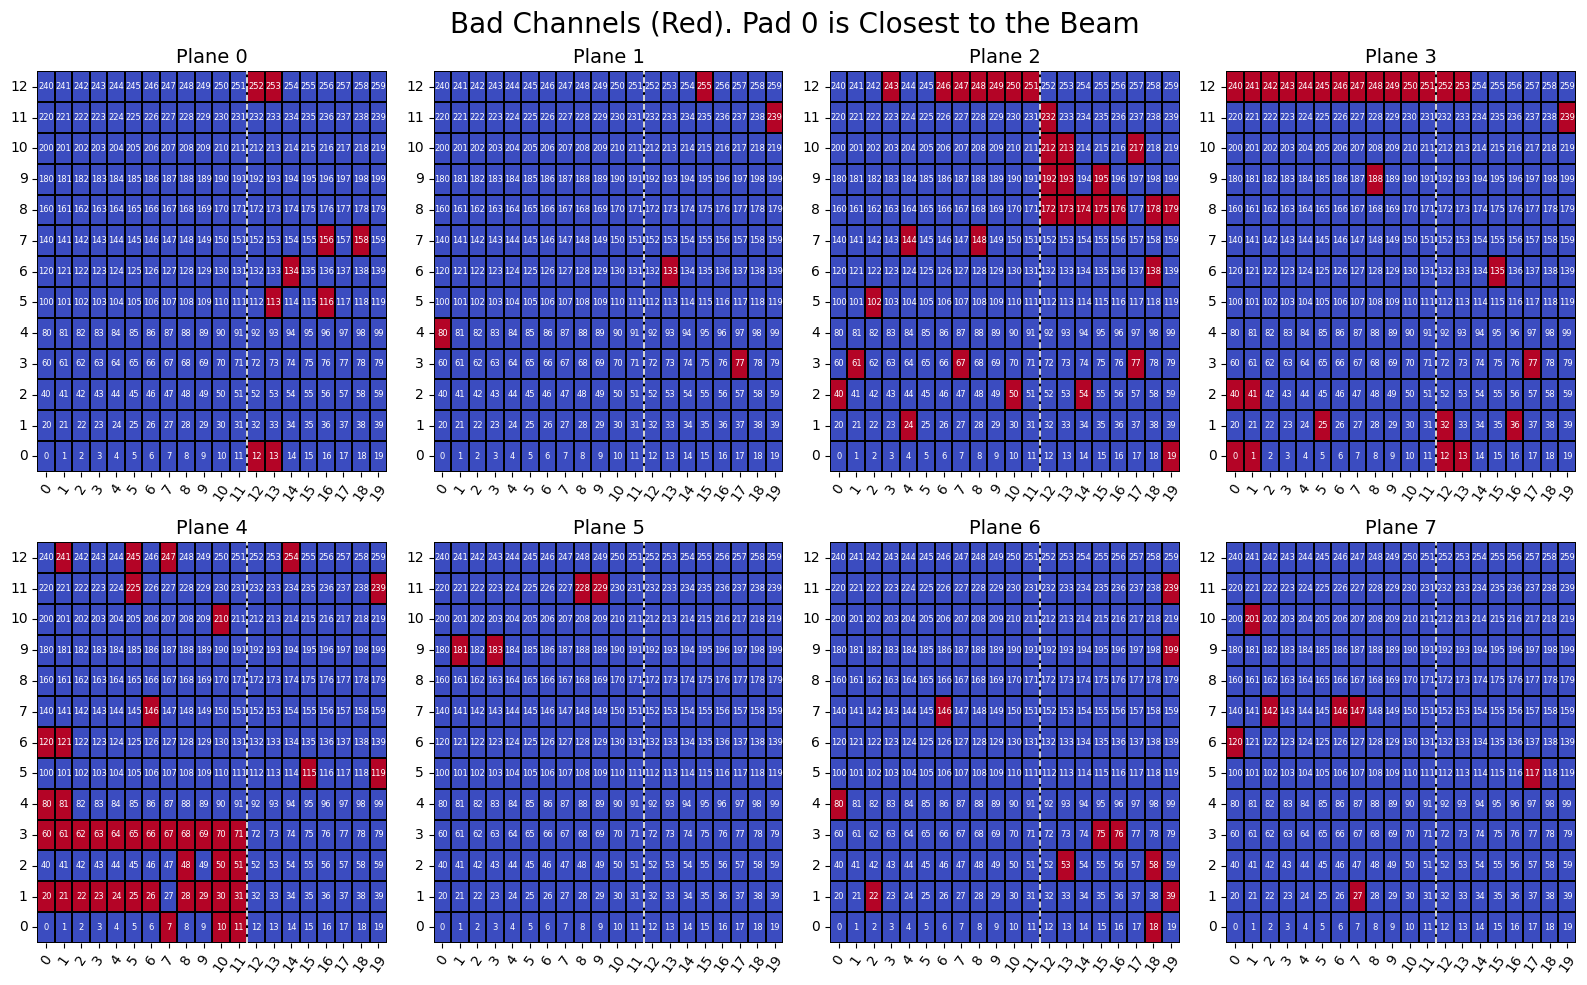

In [ ]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# get the dead channels (state the path to the diagnostic file and number of planes in your run)
def channels_diagnostics(path_to_diagnostic_file, number_of_planes):
    
    # open the diagnostic file
    infile = uproot.open(path_to_diagnostic_file)

    # get the isgood, plane_ID and channel_ID data
    isgood = infile['Diagnostics;1']['BadChannelResults']['isGood'].array()
    plane_ID = infile['Diagnostics;1']['BadChannelResults']['planeID'].array()
    channel_ID = infile['Diagnostics;1']['BadChannelResults']['channelID'].array()

    # attach channels to planes
    Y, X = divmod(channel_ID, 20)
    XY = ak.zip({ "X":X, "Y":Y})
    all_channels = ak.zip({ "plane_ID":plane_ID, "channel_ID":XY})

    # get the good and bad channels
    bad_channels = all_channels[~isgood]

    # create the matrices with the bad channels
    matrices = []
    for i in range(number_of_planes):
        bad_channel_matrix = np.zeros((13,20))

        # bad channels in the i'th plane
        bad_channels_plane_i = bad_channels[bad_channels.plane_ID == i].channel_ID

        # update the entries at the dead channels as 1
        for ch in bad_channels_plane_i:
            x = ch.X
            y = ch.Y
            bad_channel_matrix[-1-y][x] = 1

        matrices.append(bad_channel_matrix)

    # plot
    fig, axes = plt.subplots(2, 4, figsize=(16, 10))  # larger figure
    axes = axes.ravel()

    # Generate pad numbering (13×20)
    pad_numbers = np.arange(260).reshape(13, 20)

    for idx, (ax, mat) in enumerate(zip(axes, matrices)):
        
        # Plot heatmap
        sns.heatmap(
            mat,
            ax=ax,
            cmap="coolwarm",
            square=False,
            annot = pad_numbers[::-1],   # write pad numbers
            fmt="d",
            cbar = False,
            annot_kws={"size": 6},
            linewidths=0.3,
            linecolor="black"
        )

        # title for each plane
        ax.set_title(f"Plane {idx}", fontsize=14)

        # add the gap seperator
        ax.axvline( x=12, color="white", linestyle="--", linewidth=1.2)

        # X ticks (0–19)
        ax.set_xticks(np.arange(20) + 0.5)
        ax.set_xticklabels(np.arange(20), rotation = 55)

        # Y ticks (0–12)
        ax.set_yticks(np.arange(13) + 0.5)
        ax.set_yticklabels(np.arange(12, -1, -1), rotation = 0)  # bottom = 0
    
    fig.suptitle("Bad Channels (Red). Pad 0 is Closest to the Beam", fontsize = 20)
    plt.tight_layout()
    plt.show()


# run the function

# replace this with your path to the file and number of planes
path = "TB_FIRE\TB_reco\TB_FIRE_1080_raw_reco_diagnostics.root"
number_of_planes = 8

channels_diagnostics(path, number_of_planes)

<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
C:\Users\bents\AppData\Local\Temp\ipykernel_24700\2020505299.py:1: SyntaxWarning: invalid escape sequence '\T'
  path = "TB_FIRE\TB_reco\TB_FIRE_1080_raw_reco_diagnostics.root"


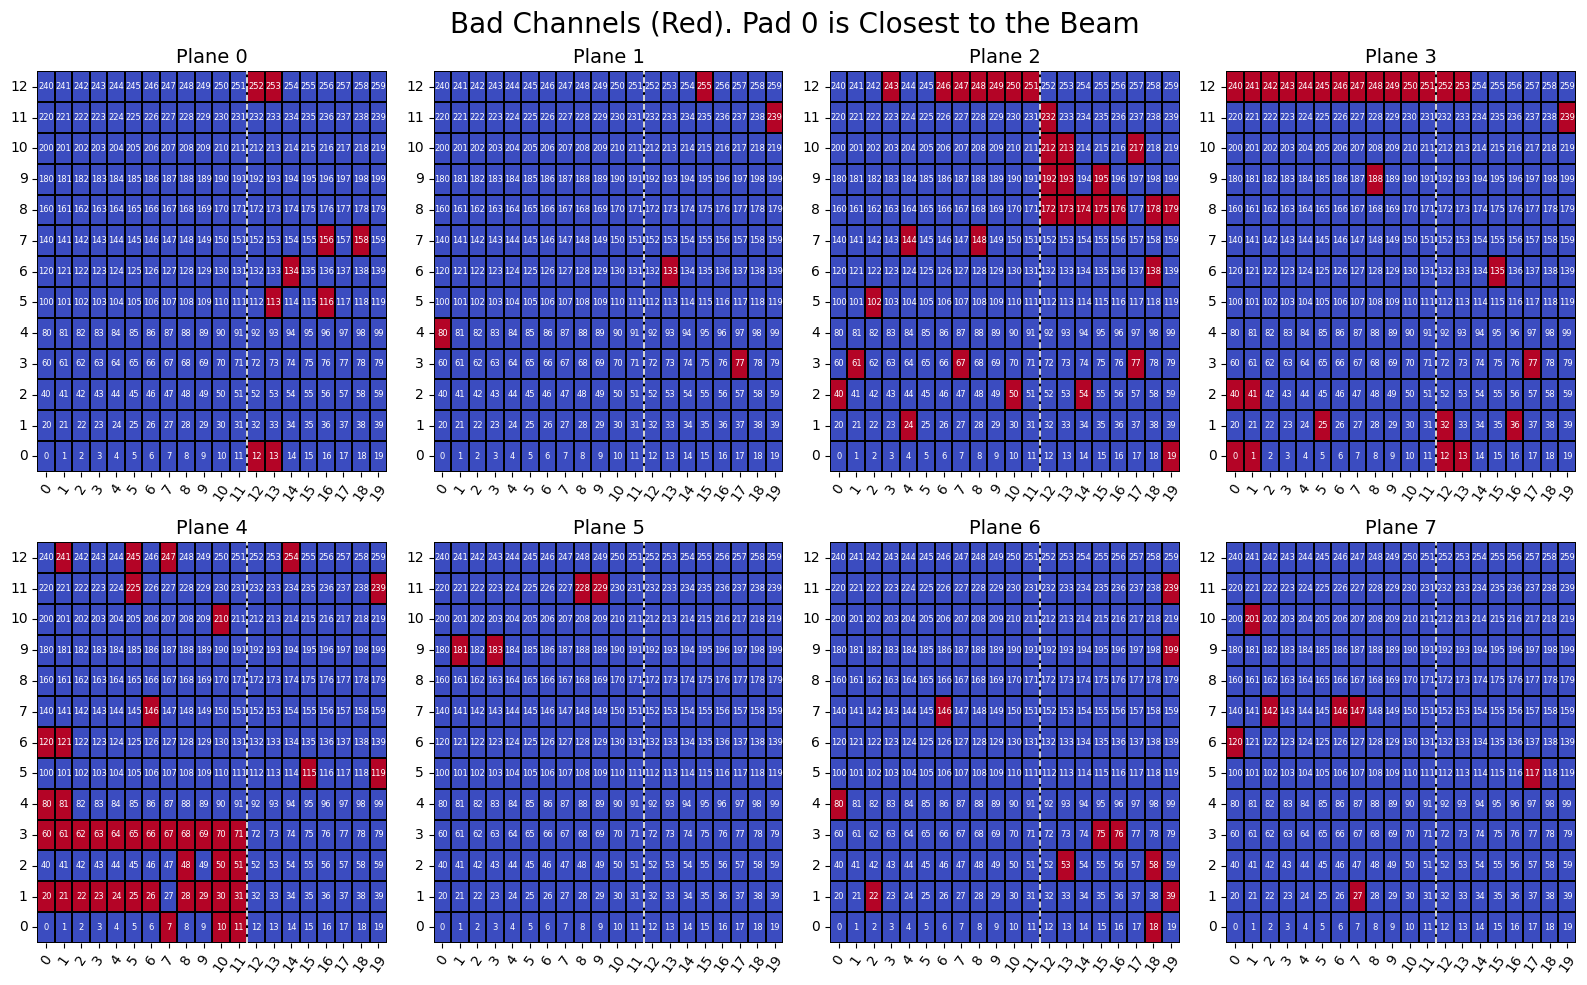

In [66]:
import uproot
import awkward as ak

path = "TB_FIRE\TB_reco\TB_FIRE_1080_raw_reco_diagnostics.root"
infile = uproot.open(path)


print(type(infile))
keys = infile.keys()
print(keys)

diagnostics = infile['Diagnostics;1']
isgood = infile['Diagnostics;1']['BadChannelResults']['isGood'].array()
plane_ID = infile['Diagnostics;1']['BadChannelResults']['planeID'].array()
channel_ID = infile['Diagnostics;1']['BadChannelResults']['channelID'].array()

print(len(isgood), len(plane_ID), len(channel_ID))

# all_channels = ak.zip({ "plane_ID":plane_ID, "channel_ID":channel_ID})
Y, X = divmod(channel_ID, 20)
XY = ak.zip({ "X":X, "Y":Y})
# all_channels = ak.zip({ "plane_ID":plane_ID, "X":X, "Y":Y})
all_channels = ak.zip({ "plane_ID":plane_ID, "channel_ID":XY})

good_channels = all_channels[isgood]
bad_channels = all_channels[~isgood]

# print bad channels in each plane
for i in range(0,8,1):
    bad_channels_plane_i = bad_channels[bad_channels.plane_ID == i].channel_ID
    print(f"Plane {i}:")
    print(bad_channels_plane_i) 


<class 'uproot.reading.ReadOnlyDirectory'>
['Diagnostics;1', 'Diagnostics/h_decoded_plane_occupancy;1', 'Diagnostics/h_reco_plane_occupancy;1', 'Diagnostics/TimestampDiagnostics;1', 'Diagnostics/TimestampDiagnostics/c_tlu_vs_ts;1', 'Diagnostics/BadChannelResults;1', 'NoiseDiagnostics;1', 'NoiseDiagnostics/h_noise_std_plane0;1', 'NoiseDiagnostics/h_noise_std_plane1;1', 'NoiseDiagnostics/h_noise_std_plane2;1', 'NoiseDiagnostics/h_noise_std_plane3;1', 'NoiseDiagnostics/h_noise_std_plane4;1', 'NoiseDiagnostics/h_noise_std_plane5;1', 'NoiseDiagnostics/h_noise_std_plane6;1', 'NoiseDiagnostics/h_noise_std_plane7;1', 'NoiseDiagnostics/ASIC_Geometry;1', 'NoiseDiagnostics/ASIC_Geometry/c_noise_heatmap_asic_plane0;1', 'NoiseDiagnostics/ASIC_Geometry/c_noise_heatmap_asic_plane1;1', 'NoiseDiagnostics/ASIC_Geometry/c_noise_heatmap_asic_plane2;1', 'NoiseDiagnostics/ASIC_Geometry/c_noise_heatmap_asic_plane3;1', 'NoiseDiagnostics/ASIC_Geometry/c_noise_heatmap_asic_plane4;1', 'NoiseDiagnostics/ASIC_Geom

<>:4: SyntaxWarning: invalid escape sequence '\T'
<>:4: SyntaxWarning: invalid escape sequence '\T'
C:\Users\bents\AppData\Local\Temp\ipykernel_24700\3729960910.py:4: SyntaxWarning: invalid escape sequence '\T'
  path = "TB_FIRE\TB_reco\TB_FIRE_1080_raw_reco_diagnostics.root"


<span style="font-family: Comic Sans MS; font-size:25px; color:orange">

Read Data In Root File Using Awkward

In [8]:
# load root file

infile_name = 'TB_FIRE\TB_reco\TB_FIRE_1088_raw_reco.root'
infile = uproot.open(infile_name)

# get headings

print(type(infile))
keys = infile.keys()
print(keys)

hits = infile['Hits']
print(type(hits))

<class 'uproot.reading.ReadOnlyDirectory'>
['Hits;1', 'BadChannelResults;1', 'SignalPulses;1']
<class 'uproot.models.TTree.Model_TTree_v20'>


<>:3: SyntaxWarning: invalid escape sequence '\T'
<>:3: SyntaxWarning: invalid escape sequence '\T'
C:\Users\bents\AppData\Local\Temp\ipykernel_22432\13849479.py:3: SyntaxWarning: invalid escape sequence '\T'
  infile_name = 'TB_FIRE\TB_reco\TB_FIRE_1088_raw_reco.root'


In [9]:
# sort all the characters of the run in arrays
tlu = hits['TLU_number'].array()
amp = hits['amplitude'].array()
toa = hits['toa'].array()
time = hits['timestamp'].array()
plane = hits['plane_ID'].array()
channel = hits['ch_ID'].array()

In [10]:
tlu

<Array [0, 1, 2, 3, ..., 503030, 503031, 503032, 503033] type='503069 * uint64'>

In [11]:
np.unique(tlu)

<Array [0, 1, 2, 3, ..., 503030, 503031, 503032, 503033] type='503033 * uint64'>

<span style="font-family: Comic Sans MS; font-size:25px; color:orange">
Deal with events and hits

In [10]:
# print some important characterisics and and present the data for different events
# notice that all arrays are of the same length
print(len(tlu))
print(tlu[10:20],"\n", amp[10:20],"\n", plane[10:20],"\n", channel[10:20])

2356797
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19] 
 [[35, 132, 85, 65, 247, 154, 150, 90, ..., 30, 36, 35, 291, 28, 22, 34], ...] 
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ..., 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7], ...] 
 [[5, 104, 121, 122, 124, 125, 144, ..., 164, 185, 143, 144, 164, 143, 144], ...]


In [11]:
# look at a single event
print(len(amp[10]),'\n',len(plane[10]),"\n",len(channel[10]))
print(tlu[10],"\n amplitude:", amp[10],"\n plane", plane[10],"\n channel", channel[10])

41 
 41 
 41
10 
 amplitude: [35, 132, 85, 65, 247, 154, 150, 90, 44, ..., 83, 30, 36, 35, 291, 28, 22, 34] 
 plane [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ..., 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7] 
 channel [5, 104, 121, 122, 124, 125, 144, 145, ..., 164, 185, 143, 144, 164, 143, 144]


In [12]:
# create characteristic string for every hit in the run
hit_data = ak.zip({ "plane":plane, "ch":channel, "amp":amp})
hit_data.show()

[[{plane: 0, ch: 128, amp: 39}, {...}, ..., {plane: 7, ch: 164, amp: 155}],
 [{plane: 0, ch: 126, amp: 13}, {...}, ..., {plane: 6, ch: 184, amp: 28}],
 [{plane: 0, ch: 166, amp: 17}, {...}, ..., {plane: 7, ch: 186, amp: 89}],
 [{plane: 0, ch: 164, amp: 87}, {...}, ..., {plane: 7, ch: 184, amp: 130}],
 [{plane: 0, ch: 102, amp: 50}, {...}, ..., {plane: 7, ch: 163, amp: 83}],
 [{plane: 0, ch: 120, amp: 21}, {...}, ..., {plane: 7, ch: 165, amp: 230}],
 [{plane: 0, ch: 105, amp: 52}, {...}, ..., {plane: 7, ch: 145, amp: 168}],
 [{plane: 0, ch: 144, amp: 12}, {...}, ..., {plane: 7, ch: 167, amp: 23}],
 [{plane: 0, ch: 125, amp: 35}, {...}, ..., {plane: 7, ch: 166, amp: 117}],
 [{plane: 0, ch: 87, amp: 17}, {...}, ..., {...}, {plane: 7, ch: 145, amp: 32}],
 ...,
 [{plane: 5, ch: 169, amp: 21}, {...}, ..., {plane: 6, ch: 183, amp: 248}],
 [{plane: 5, ch: 28, amp: 164}, {...}, ..., {plane: 6, ch: 203, amp: 16}],
 [{plane: 5, ch: 70, amp: 52}, {plane: 5, ch: 165, amp: 175}],
 [{plane: 5, ch: 12

In [13]:
# create triplets of for each hit for a specific TLU
triplets = ak.zip({"amp":amp[10], "plane":plane[10], "ch":channel[10]}).show()
# triplets = ak.zip([amp[10], plane[10], channel[10]]).show()


[{amp: 35, plane: 0, ch: 5},
 {amp: 132, plane: 0, ch: 104},
 {amp: 85, plane: 0, ch: 121},
 {amp: 65, plane: 0, ch: 122},
 {amp: 247, plane: 0, ch: 124},
 {amp: 154, plane: 0, ch: 125},
 {amp: 150, plane: 0, ch: 144},
 {amp: 90, plane: 0, ch: 145},
 {amp: 44, plane: 0, ch: 164},
 {amp: 11, plane: 1, ch: 123},
 ...,
 {amp: 107, plane: 5, ch: 125},
 {amp: 83, plane: 5, ch: 143},
 {amp: 30, plane: 5, ch: 164},
 {amp: 36, plane: 5, ch: 185},
 {amp: 35, plane: 6, ch: 143},
 {amp: 291, plane: 6, ch: 144},
 {amp: 28, plane: 6, ch: 164},
 {amp: 22, plane: 7, ch: 143},
 {amp: 34, plane: 7, ch: 144}]


<span style="font-family: Comic Sans MS; font-size:25px; color:orange">
Introducing "Awkward" library

[39, 27, 183, 73, 435, 83, 38, 63, 32, ..., 70, 56, 107, 53, 356, 61, 29, 67]


Text(0, 0.5, 'Counts')

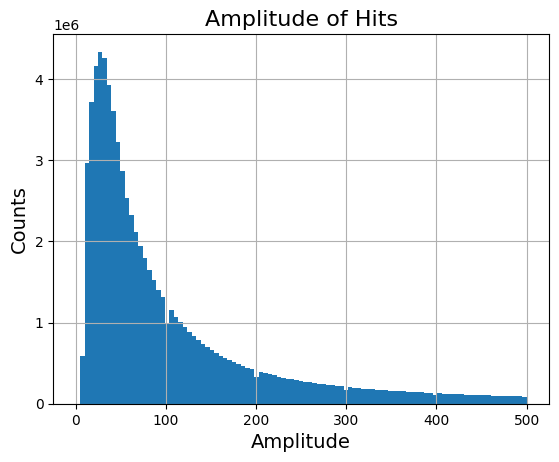

In [24]:
# creating an hitsogram using ak flattening



print(ak.flatten(amp))
plt.figure()
plt.hist(ak.flatten(amp),bins=101,range=(0,500))
# plt.hist(ak.flatten(amp),bins=100)
plt.grid()
plt.title('Amplitude of Hits',fontsize=16)
plt.xlabel('Amplitude',fontsize=14)
plt.ylabel('Counts',fontsize=14)


In [15]:
# use awkward to show all compbinations (permutations) to organize elements from an array in n sized list
a = ak.Array([1,2,3,4,5])
n = 3
ak.combinations(a, n, axis=0).show()

print()

# can also work simultaneousley on different sized sub arrays
b = ak.Array([[1,2,3,4], [20,40,50], [5,6], []])
ak.combinations(b, n).show()

[(1, 2, 3),
 (1, 2, 4),
 (1, 2, 5),
 (1, 3, 4),
 (1, 3, 5),
 (1, 4, 5),
 (2, 3, 4),
 (2, 3, 5),
 (2, 4, 5),
 (3, 4, 5)]

[[(1, 2, 3), (1, 2, 4), (1, 3, 4), (2, 3, 4)],
 [(20, 40, 50)],
 [],
 []]


In [16]:
# create a set of values (x and y)
c = ak.Array([[1,2,3],[40,50]])
ak.combinations(c, 2, fields=["x", "y"]).show()

[[{x: 1, y: 2}, {x: 1, y: 3}, {x: 2, y: 3}],
 [{x: 40, y: 50}]]


In [17]:
# unzip on awkward
numbers = ak.Array([[1, 2, 3], [], [5, 7], [11]])
letters = ak.Array([["a", "b"], ["c"], ["d"], ["e", "f"]])
notes = ak.Array([["la", "mi"], ["ci"], ["do"], ["re", "fa"]])

trios = ak.cartesian((numbers, letters,notes))
# print(trios)
trios.show()
print()

numbers,letters,notes = ak.unzip(trios)
print(numbers)
print()
print(letters)
print()
print(notes)


[[(1, 'a', 'la'), (1, 'a', 'mi'), (...), ..., (3, 'b', 'la'), (3, 'b', 'mi')],
 [],
 [(5, 'd', 'do'), (7, 'd', 'do')],
 [(11, 'e', 're'), (11, 'e', 'fa'), (11, 'f', 're'), (11, 'f', 'fa')]]

[[1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3], [], [5, 7], [11, 11, 11, 11]]

[['a', 'a', 'b', 'b', 'a', 'a', 'b', 'b', 'a', 'a', 'b', 'b'], ..., ['e', ...]]

[['la', 'mi', 'la', 'mi', 'la', 'mi', ..., 'mi', 'la', 'mi', 'la', 'mi'], ...]


In [18]:
ak.zip({"number":numbers,"letter":letters,"note":notes}).show()
print()
ak.zip([numbers,letters,notes]).show()

[[{number: 1, letter: 'a', note: 'la'}, ..., {number: 3, letter: 'b', ...}],
 [],
 [{number: 5, letter: 'd', note: 'do'}, {number: 7, letter: 'd', ...}],
 [{number: 11, letter: 'e', note: 're'}, ..., {number: 11, letter: 'f', ...}]]

[[(1, 'a', 'la'), (1, 'a', 'mi'), (...), ..., (3, 'b', 'la'), (3, 'b', 'mi')],
 [],
 [(5, 'd', 'do'), (7, 'd', 'do')],
 [(11, 'e', 're'), (11, 'e', 'fa'), (11, 'f', 're'), (11, 'f', 'fa')]]


In [19]:
one = ak.Array([[1.1, 2.2, 3.3], [], [4.4, 5.5], [6.6],])
two = ak.Array([["a", "b", "c"], [], ["d", "e"], ["f"]])


In [20]:
three = ak.Array([100,200,300,400])
ak.zip([one,two,three]).show()

[[(1.1, 'a', 100), (2.2, 'b', 100), (3.3, 'c', 100)],
 [],
 [(4.4, 'd', 300), (5.5, 'e', 300)],
 [(6.6, 'f', 400)]]


In [21]:
three = ak.Array([[],200,300,400])
ak.zip([one,two,three],depth_limit=1).show()

[([1.1, 2.2, 3.3], ['a', 'b', 'c'], []),
 ([], [], 200),
 ([4.4, 5.5], ['d', 'e'], 300),
 ([6.6], ['f'], 400)]
